# Feature Selection using ReliefF
https://epistasislab.github.io/scikit-rebate/using/
`pip install skrebate`

In [1]:
import pandas as pd
import numpy as np
from skrebate import ReliefF
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt 

In [2]:
seg_data = pd.read_csv('segmentation-all.csv')
print(seg_data.shape)
seg_data.head()

(2310, 20)


,Class,REGION-CENTROID-COL,REGION-CENTROID-ROW,REGION-PIXEL-COUNT,SHORT-LINE-DENSITY-5,SHORT-LINE-DENSITY-2,VEDGE-MEAN,VEDGE-SD,HEDGE-MEAN,HEDGE-SD,INTENSITY-MEAN,RAWRED-MEAN,RAWBLUE-MEAN,RAWGREEN-MEAN,EXRED-MEAN,EXBLUE-MEAN,EXGREEN-MEAN,VALUE-MEAN,SATURATION-MEAN,HUE-MEAN
0,BRICKFACE,140.0,125.0,9,0.0,0.0,0.277778,0.062963,0.666667,0.311111,6.185185,7.333334,7.666666,3.555556,3.444444,4.444445,-7.888889,7.777778,0.545635,-1.121818
1,BRICKFACE,188.0,133.0,9,0.0,0.0,0.333333,0.266667,0.500000,0.077778,6.666666,8.333334,7.777778,3.888889,5.000000,3.333333,-8.333333,8.444445,0.538580,-0.924817
2,BRICKFACE,105.0,139.0,9,0.0,0.0,0.277778,0.107407,0.833333,0.522222,6.111111,7.555555,7.222222,3.555556,4.333334,3.333333,-7.666666,7.555555,0.532628,-0.965946
3,BRICKFACE,34.0,137.0,9,0.0,0.0,0.500000,0.166667,1.111111,0.474074,5.851852,7.777778,6.444445,3.333333,5.777778,1.777778,-7.555555,7.777778,0.573633,-0.744272
4,BRICKFACE,39.0,111.0,9,0.0,0.0,0.722222,0.374074,0.888889,0.429629,6.037037,7.000000,7.666666,3.444444,2.888889,4.888889,-7.777778,7.888889,0.562919,-1.175773


In [3]:
seg_data['Class'].value_counts()

GRASS        330
PATH         330
FOLIAGE      330
BRICKFACE    330
CEMENT       330
SKY          330
WINDOW       330
Name: Class, dtype: int64

Load the data, scale it and divide into train and test sets.  
The filters are *trained* using the training data and then a classifier is trained on the feature subset and tested on the test set. 

In [4]:
y = seg_data.pop('Class').values
X_raw = seg_data.values

X_tr_raw, X_ts_raw, y_train, y_test = train_test_split(X_raw, y, 
                                                       random_state=42, test_size=1/2)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_tr_raw)
X_test = scaler.transform(X_ts_raw)

feature_names = seg_data.columns
X_train.shape, X_test.shape

((1155, 19), (1155, 19))

### ReliefF
- `ReliefF` will produce scores for all features.
- `n_features_to_select` controls the transform behaviour, if a dataset is transformed this number of features will be retained. 

In [5]:
reliefFS = ReliefF(n_features_to_select=11, n_neighbors=100, n_jobs = -1)

In [6]:
reliefFS.fit(X_train,y_train)

ReliefF(n_features_to_select=11, n_jobs=-1)

In [7]:
relief_scores = reliefFS.feature_importances_

In [8]:
reliefFS.transform(X_train).shape

(1155, 11)

Also calcuate I-Gain scores: to be used for comparision.

In [9]:
i_scores = mutual_info_classif(X_train,y_train)
i_scores
# The i-gain scores for the features

array([0.17248192, 0.97683444, 0.        , 0.05280402, 0.        ,
       0.51807124, 0.34326861, 0.45565522, 0.3684127 , 1.14823715,
       1.22236758, 1.08093769, 1.11012057, 0.76024702, 0.90819855,
       0.96765296, 1.11173206, 0.95148201, 1.14925701])

In [10]:
from scipy import stats
stats.spearmanr(relief_scores, i_scores)

SpearmanrResult(correlation=0.8222905574401099, pvalue=1.5584964080854542e-05)

Store the ReliefF and I-Gain scores in a dataframe.  
**Note:** The mutual information score returned by `mutual_info_classif` is effectively an information gain score.  

In [11]:
df=pd.DataFrame({'Mutual Info.':i_scores,'ReliefF':relief_scores,'Feature':feature_names})
df.set_index('Feature', inplace = True)
df.sort_values('Mutual Info.', inplace = True, ascending = False)
df

,Mutual Info.,ReliefF
Feature,,
RAWRED-MEAN,1.222368,0.412081
HUE-MEAN,1.149257,0.294419
INTENSITY-MEAN,1.148237,0.415412
VALUE-MEAN,1.111732,0.429128
RAWGREEN-MEAN,1.110121,0.390963
RAWBLUE-MEAN,1.080938,0.437259
REGION-CENTROID-ROW,0.976834,0.408392
EXGREEN-MEAN,0.967653,0.411451
SATURATION-MEAN,0.951482,0.331558


### Plotting the ReliefF and I-Gain scores
We see that the two scores are fairly well correlated.  
The Spearman correlation is 0.81.

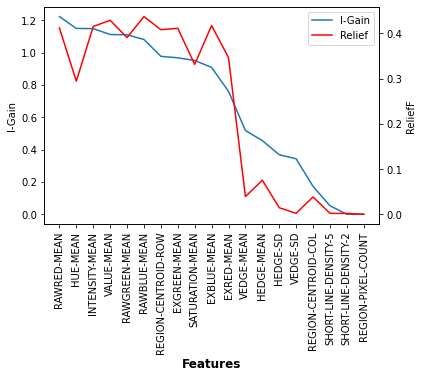

In [12]:
fig, ax = plt.subplots()
rr = range(0,len(feature_names))
ax2 = ax.twinx()
ax.plot(df.index, df["Mutual Info."], label='I-Gain')
ax2.plot(df.index, df["ReliefF"], color='red', label='Relief')
ax.set_xticks(rr)

ax.set_xticklabels(list(df.index), rotation = 90)
ax.set_xlabel('Features', fontsize=12, fontweight='bold')
ax.set_ylabel('I-Gain')
ax2.set_ylabel('ReliefF')
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax.transAxes)

## Feature Selection
Compare  
- Baseline: all features
- Visual inspection of the ReliefF plot suggests we select the top 11 features. 

### Baseline Classifier

In [13]:
model = KNeighborsClassifier(n_neighbors=3)
model = model.fit(X_train,y_train)
y_pred = model.predict(X_test)
acc_all = accuracy_score(y_pred,y_test)
acc_all

0.935064935064935

In [14]:
n_features = X_train.shape[1]
n_features

19

### After feature selection
We produce a reduced dataset with the 11 top ranking features selected by ReliefF

In [15]:
X_tr_relief = reliefFS.transform(X_train)
X_ts_relief = reliefFS.transform(X_test)
X_tr_relief.shape

(1155, 11)

In [16]:
kNN_relief = model.fit(X_tr_relief,y_train)
y_pred = kNN_relief.predict(X_ts_relief)
acc_11 = accuracy_score(y_pred,y_test)
acc_11

0.9515151515151515

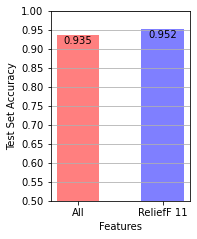

In [17]:
import matplotlib.pyplot as plt 
import numpy as np
%matplotlib inline 

fig, ax = plt.subplots(figsize=(2.5,3.5))
width = 0.5
sb = 'skyblue'

options = ['All', 'ReliefF 11']
scores = [acc_all,acc_11]

y_pos = np.arange(len(options))

p1 = ax.bar(y_pos, scores, width, align='center', 
            color=['red', 'blue'],alpha=0.5)

ax.set_ylim([0.5, 1])
plt.grid(axis = 'y')
plt.yticks(np.arange(0.5,1.05,0.05))
ax.text(0,acc_all, '%0.3f' % acc_all, ha='center', va = 'top')
ax.text(1,acc_11, '%0.3f' % acc_11, ha='center',va = 'top')

plt.xticks(y_pos, options)
plt.ylabel('Test Set Accuracy')
plt.xlabel('Features')
plt.show()